# Seq2seq model using attention, focusing on which words to "pay attention to" and which are "most important"

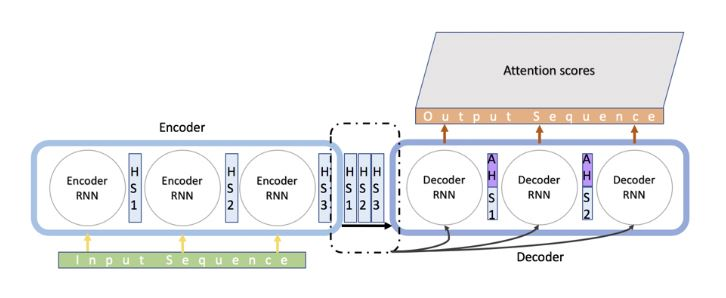

In [76]:
from IPython.display import Image
Image(filename='AttentionImage.jpg')
# image credits https://towardsdatascience.com/day-1-2-attention-seq2seq-models-65df3f49e263

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re                      # Regular expressions
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout,  Dense, Activation,Add, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\R-k-l\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\R-k-l\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\R-k-l\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


### Perform the following tasks on the data:
- Convert everything to lowercase
- Remove HTML tags
- Contraction mapping
- Remove (‘s)
- Remove any text inside the parenthesis ( )
- Eliminate punctuations and special characters
- Remove stopwords
- Remove shortwords

In [2]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [3]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    """
    text (str): a string of text that can be multiple sentences to be parsed into a token stream. 
    Returns: a cleaned string of text
    """
    newString = text.lower()
    newString = BeautifulSoup(newString, exclude_encodings="lxml").text # removes html/xml taggs
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()


## Import data to train model on in csv format

In [4]:
df_art_sum = pd.read_csv("train_model_files/article_summary_and_article_title/sample_1000.csv")
# bbc_art_sum.drop("Unnamed: 0", axis=1, inplace=True)
print(df_art_sum.shape)
df_art_sum.head()

(1000, 2)


,article,title
0,"russian foreign minister igor ivanov said tuesday that he and new secretary of state colin powell will hold their first meeting on feb. ## in cairo , egypt .",ivanov powell to meet this month
1,"french aerobatic team `` patrouille de france '' will stage an exciting performance in hong kong on oct. ## during its first visit to china , according to a press release issued by the consulate g...",french aerobatic team to stage performance in hk
2,spanish farmers hurled several thousand kilos -lrb- pounds -rrb- of tomatoes and eggs at the french embassy on saturday in reprisal for attacks on spanish produce in france .,spanish farmers hurl produce at french embassy
3,"european share retreated thursday , tracking declines on wall street , with technology stocks posting heavy losses after a bearish earnings outlook from nokia for the fourth quarter .",euro stocks slip on wall street losses nokia
4,a judge on wednesday said he will not impanel a new jury to decide whether to spare the life a man convicted in the bombing of a u.s. embassy in africa .,embassy bombings judge to keep jury


In [5]:
df_art_sum.shape

(1000, 2)

In [6]:
cleaned = []
for t in df_art_sum['title']:
    cleaned.append(text_cleaner(t))
df_art_sum['clean_summary'] = cleaned
df_art_sum['clean_summary'] = df_art_sum['clean_summary'].apply(lambda x : '_START_ '+ x + ' _END_')
df_art_sum.head()

,article,title,clean_summary
0,"russian foreign minister igor ivanov said tuesday that he and new secretary of state colin powell will hold their first meeting on feb. ## in cairo , egypt .",ivanov powell to meet this month,_START_ ivanov powell meet month _END_
1,"french aerobatic team `` patrouille de france '' will stage an exciting performance in hong kong on oct. ## during its first visit to china , according to a press release issued by the consulate g...",french aerobatic team to stage performance in hk,_START_ french aerobatic team stage performance _END_
2,spanish farmers hurled several thousand kilos -lrb- pounds -rrb- of tomatoes and eggs at the french embassy on saturday in reprisal for attacks on spanish produce in france .,spanish farmers hurl produce at french embassy,_START_ spanish farmers hurl produce french embassy _END_
3,"european share retreated thursday , tracking declines on wall street , with technology stocks posting heavy losses after a bearish earnings outlook from nokia for the fourth quarter .",euro stocks slip on wall street losses nokia,_START_ euro stocks slip wall street losses nokia _END_
4,a judge on wednesday said he will not impanel a new jury to decide whether to spare the life a man convicted in the bombing of a u.s. embassy in africa .,embassy bombings judge to keep jury,_START_ embassy bombings judge keep jury _END_


In [7]:
cleaned.clear()
for t in df_art_sum['article']:
    cleaned.append(text_cleaner(t))
df_art_sum['clean_text'] = cleaned
df_art_sum.head()

,article,title,clean_summary,clean_text
0,"russian foreign minister igor ivanov said tuesday that he and new secretary of state colin powell will hold their first meeting on feb. ## in cairo , egypt .",ivanov powell to meet this month,_START_ ivanov powell meet month _END_,russian foreign minister igor ivanov said tuesday new secretary state colin powell hold first meeting feb cairo egypt
1,"french aerobatic team `` patrouille de france '' will stage an exciting performance in hong kong on oct. ## during its first visit to china , according to a press release issued by the consulate g...",french aerobatic team to stage performance in hk,_START_ french aerobatic team stage performance _END_,french aerobatic team patrouille france stage exciting performance hong kong oct first visit china according press release issued consulate general france hong kong wednesday
2,spanish farmers hurled several thousand kilos -lrb- pounds -rrb- of tomatoes and eggs at the french embassy on saturday in reprisal for attacks on spanish produce in france .,spanish farmers hurl produce at french embassy,_START_ spanish farmers hurl produce french embassy _END_,spanish farmers hurled several thousand kilos lrb pounds rrb tomatoes eggs french embassy saturday reprisal attacks spanish produce france
3,"european share retreated thursday , tracking declines on wall street , with technology stocks posting heavy losses after a bearish earnings outlook from nokia for the fourth quarter .",euro stocks slip on wall street losses nokia,_START_ euro stocks slip wall street losses nokia _END_,european share retreated thursday tracking declines wall street technology stocks posting heavy losses bearish earnings outlook nokia fourth quarter
4,a judge on wednesday said he will not impanel a new jury to decide whether to spare the life a man convicted in the bombing of a u.s. embassy in africa .,embassy bombings judge to keep jury,_START_ embassy bombings judge keep jury _END_,judge wednesday said impanel new jury decide whether spare life man convicted bombing embassy africa


## Tokenize list data into sequences

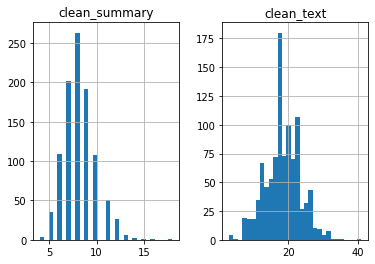

In [8]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df_art_sum['clean_text']:
      text_word_count.append(len(i.split()))

for i in df_art_sum['clean_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'clean_text':text_word_count, 'clean_summary':summary_word_count})
length_df.hist(bins = 30)
plt.show() # x-axis length, y-axis distribution

### Find which value the majority of the text is in. Need to find a way to automate the article-title maximum distribution, instead of doing it by 'eye' from the plots above. For now just use article <= 27, title <=10

## Tokenize then Pad sequences, used in model building

In [56]:
max_len_text=27 # shown in graphs above. Find a way to automate instead of changing it by 'eye'
max_len_summary=10

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
articles = list(df_art_sum.clean_text)
summaries = list(df_art_sum.clean_summary)

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(df_art_sum['clean_text'],df_art_sum['clean_summary'],test_size=0.1,
#                                        random_state=1,
                                       shuffle=True) 

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

# convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

# padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1
print('x_voc_size:', x_voc_size)

# preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

# convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

# padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1
print('y_voc_size:', y_voc_size)

x_voc_size: 5865
y_voc_size: 2907


## Create embeddings for the 

In [57]:
y_tokenizer.word_index

{'end': 1,
 'start': 2,
 'says': 3,
 'china': 4,
 'new': 5,
 'hong': 6,
 'kong': 7,
 'iraq': 8,
 'court': 9,
 'first': 10,
 'world': 11,
 'bush': 12,
 'government': 13,
 'police': 14,
 'year': 15,
 'million': 16,
 'calls': 17,
 'chinese': 18,
 'leader': 19,
 'plan': 20,
 'shares': 21,
 'open': 22,
 'lower': 23,
 'stocks': 24,
 'president': 25,
 'killed': 26,
 'french': 27,
 'two': 28,
 'iran': 29,
 'military': 30,
 'deal': 31,
 'close': 32,
 'official': 33,
 'death': 34,
 'percent': 35,
 'talks': 36,
 'european': 37,
 'minister': 38,
 'bank': 39,
 'foreign': 40,
 'troops': 41,
 'law': 42,
 'oil': 43,
 'make': 44,
 'could': 45,
 'british': 46,
 'russian': 47,
 'election': 48,
 'parliament': 49,
 'dollars': 50,
 'higher': 51,
 'africa': 52,
 'wins': 53,
 'back': 54,
 'rights': 55,
 'three': 56,
 'trade': 57,
 'anti': 58,
 'gold': 59,
 'russia': 60,
 'state': 61,
 'may': 62,
 'egypt': 63,
 'injured': 64,
 'cup': 65,
 'opens': 66,
 'people': 67,
 'campaign': 68,
 'sign': 69,
 'meet': 70,
 

## Use padded sequences to manually create inputs to encoder and decoders

## Embedding layers using GloVe

In [58]:
from load_glove_embeddings import load_glove_embeddings # local function from .py file
glove_dimension = 50
import time
timer_start = time.time()
word2index, embedding_matrix = load_glove_embeddings('../glove.6B.'+str(glove_dimension)+'d.txt', embedding_dim=glove_dimension, include_empty_char=False)
print('Found %s word vectors.' % len(word2index))
print("Creating embeddings_index took", round(time.time() - timer_start, 1), "seconds.")
del timer_start

Found 400000 word vectors.
Creating embeddings_index took 11.6 seconds.


In [59]:
embedding_matrix

array([[ 0.41800001,  0.24968   , -0.41242   , ..., -0.18411   ,
        -0.11514   , -0.78580999],
       [ 0.013441  ,  0.23682   , -0.16899   , ..., -0.56656998,
         0.044691  ,  0.30392   ],
       [ 0.15164   ,  0.30177   , -0.16763   , ..., -0.35652   ,
         0.016413  ,  0.10216   ],
       ...,
       [-0.51181   ,  0.058706  ,  1.09130001, ..., -0.25003001,
        -1.125     ,  1.58630002],
       [-0.75897998, -0.47426   ,  0.47369999, ...,  0.78953999,
        -0.014116  ,  0.64480001],
       [ 0.072617  , -0.51393002,  0.47279999, ..., -0.18907   ,
        -0.59021002,  0.55558997]])

In [60]:
word2index

{'the': 0,
 ',': 1,
 '.': 2,
 'of': 3,
 'to': 4,
 'and': 5,
 'in': 6,
 'a': 7,
 '"': 8,
 "'s": 9,
 'for': 10,
 '-': 11,
 'that': 12,
 'on': 13,
 'is': 14,
 'was': 15,
 'said': 16,
 'with': 17,
 'he': 18,
 'as': 19,
 'it': 20,
 'by': 21,
 'at': 22,
 '(': 23,
 ')': 24,
 'from': 25,
 'his': 26,
 "''": 27,
 '``': 28,
 'an': 29,
 'be': 30,
 'has': 31,
 'are': 32,
 'have': 33,
 'but': 34,
 'were': 35,
 'not': 36,
 'this': 37,
 'who': 38,
 'they': 39,
 'had': 40,
 'i': 41,
 'which': 42,
 'will': 43,
 'their': 44,
 ':': 45,
 'or': 46,
 'its': 47,
 'one': 48,
 'after': 49,
 'new': 50,
 'been': 51,
 'also': 52,
 'we': 53,
 'would': 54,
 'two': 55,
 'more': 56,
 "'": 57,
 'first': 58,
 'about': 59,
 'up': 60,
 'when': 61,
 'year': 62,
 'there': 63,
 'all': 64,
 '--': 65,
 'out': 66,
 'she': 67,
 'other': 68,
 'people': 69,
 "n't": 70,
 'her': 71,
 'percent': 72,
 'than': 73,
 'over': 74,
 'into': 75,
 'last': 76,
 'some': 77,
 'government': 78,
 'time': 79,
 '$': 80,
 'you': 81,
 'years': 82,
 'i

In [61]:
def embedding_matrix_creater(embedding_dimention, word_index): 
    """
    Uses GloVe as a global word embedding. 
    
    embedding_dimention: usually in the title of glove.6D.'embedding_dimention', in this notebook use 50. 
    word_index: the input word embeddings
    
    returns: a local embedding matrix, to be input as weights [embedding] for the constructor
        for keras' Embedding object. 
    """
    local_embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimention))
    for word, i in word_index.items():
        embedding_vector = word2index.get(word) # from cell above, from glove.
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            local_embedding_matrix[i] = embedding_vector
    return local_embedding_matrix

In [62]:
text_embedding_matrix = embedding_matrix_creater(glove_dimension, word_index=x_tokenizer.word_index) 
print(text_embedding_matrix.shape)

sum_embedding_matrix = embedding_matrix_creater(glove_dimension, word_index=y_tokenizer.word_index)
print(sum_embedding_matrix.shape)

encoder_embedding_layer = Embedding(input_dim = int(text_embedding_matrix.shape[0]), # vocab size
                                    output_dim = int(text_embedding_matrix.shape[1]), # embedding dimension
                                    input_length = max_len_text,
                                    weights = [text_embedding_matrix],
                                    trainable = False)

decoder_embedding_layer = Embedding(input_dim = int(sum_embedding_matrix.shape[0]), 
                                    output_dim = int(sum_embedding_matrix.shape[1]),
                                    input_length = max_len_summary,
                                    weights = [sum_embedding_matrix],
                                    trainable = False)

(5865, 50)
(2907, 50)


In [63]:
text_embedding_matrix

array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.6000e+01, 1.6000e+01, 1.6000e+01, ..., 1.6000e+01, 1.6000e+01,
        1.6000e+01],
       [1.7700e+02, 1.7700e+02, 1.7700e+02, ..., 1.7700e+02, 1.7700e+02,
        1.7700e+02],
       ...,
       [1.9820e+03, 1.9820e+03, 1.9820e+03, ..., 1.9820e+03, 1.9820e+03,
        1.9820e+03],
       [1.7334e+04, 1.7334e+04, 1.7334e+04, ..., 1.7334e+04, 1.7334e+04,
        1.7334e+04],
       [7.1710e+03, 7.1710e+03, 7.1710e+03, ..., 7.1710e+03, 7.1710e+03,
        7.1710e+03]])

## Model architecture finished. Train and validate the model. 

In [82]:
from attention import AttentionLayer
HIDDEN_UNITS = 300

# Encoder
encoder_inputs = Input(shape=(max_len_text,))

#embedding layer
enc_emb =  encoder_embedding_layer(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(HIDDEN_UNITS,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(HIDDEN_UNITS,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(HIDDEN_UNITS, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 27)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 27, 50)       293250      input_14[0][0]                   
__________________________________________________________________________________________________
lstm_22 (LSTM)                  [(None, 27, 300), (N 421200      embedding_7[0][0]                
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

In [83]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy') # good for one-hot encoding on the fly

In [84]:
history=model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],
                  y_tr.shape[1], 1)[:,1:],
                  epochs=10,
#                   callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
                  batch_size=32,
                  validation_data=([x_val,y_val[:,:-1]],y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Train on 900 samples, validate on 100 samples
Epoch 1/10
900/900 [==============================] - 36s 40ms/sample - loss: 6.1747 - val_loss: 3.7906
Epoch 2/10
900/900 [==============================] - 30s 33ms/sample - loss: 5.6827 - val_loss: 3.9829
Epoch 3/10
900/900 [==============================] - 30s 33ms/sample - loss: 5.6207 - val_loss: 3.9784
Epoch 4/10
900/900 [==============================] - 30s 34ms/sample - loss: 5.5761 - val_loss: 3.7818
Epoch 5/10
900/900 [==============================] - 30s 34ms/sample - loss: 5.5545 - val_loss: 3.9573
Epoch 6/10
900/900 [==============================] - 31s 34ms/sample - loss: 5.5068 - val_loss: 3.9230
Epoch 7/10
900/900 [==============================] - 30s 34ms/sample - loss: 5.4965 - val_loss: 3.9276
Epoch 8/10
900/900 [==============================] - 31s 34ms/sample - loss: 5.4784 - val_loss: 3.9590
Epoch 9/10
900/900 [==============================] - 31s 35ms/sample - loss: 5.4477 - val_loss: 3.9622
Epoch 10/10
900/90

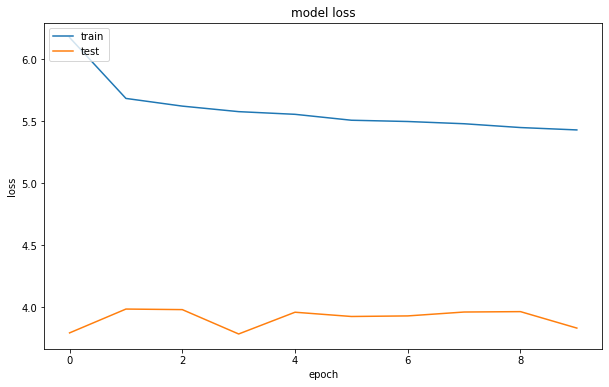

In [85]:
from matplotlib import pyplot
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [86]:
history.history

{'loss': [6.174712312486436,
  5.682722125583225,
  5.62069697909885,
  5.576086271074083,
  5.554470460679796,
  5.506753470102946,
  5.496505614386664,
  5.478406035105388,
  5.44771887673272,
  5.428511873881022],
 'val_loss': [3.790561933517456,
  3.9829093837738037,
  3.978433952331543,
  3.781829490661621,
  3.957324504852295,
  3.9229745864868164,
  3.927563591003418,
  3.9589805126190187,
  3.9621846580505373,
  3.829400043487549]}

In [ ]:
"""
# Save model.
with open('text_summary.json',"w").write(model.to_json())
model.load_weights('text_summary.h5')
print("Saved Model!")
"""